In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from ahrs.filters import Madgwick
from scipy.spatial.transform import Rotation as R
#from filtros import files_xsensexporter_grouping as test1
from mpl_toolkits.mplot3d import Axes3D
from pythreejs import *
from IPython.display import display
import time
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from vpython import canvas, cylinder, vector, color, rate, button
import gc

<IPython.core.display.Javascript object>

In [2]:
gc.collect()

22

In [ ]:
# Ingresar la ruta de la carpeta principal
main_folder = input("Ingresa la ruta de la carpeta principal: ")
test1.group_csv_files_by_suffix(main_folder)

 Necesitamos almacenar y promediar la calibración estatica de cada sensor 

In [2]:
def acc_static_calibration(main_folder_path):
    """
    Calibra la aceleración de archivos estáticos CSV en subcarpetas y genera archivos de salida con
    promedios de aceleración en términos de g y m/s². g es necesario para obtener A y b con Magneto y m/s² para
    generar posteriormente el filtro de Madgwick.

    Parámetros:
    - main_folder_path: Ruta a la carpeta principal que contiene subcarpetas para cada sensor: static_sensors
    """
    # Recorre todas las subcarpetas en la carpeta principal
    for sensor_folder in os.listdir(main_folder_path):
        sensor_path = os.path.join(main_folder_path, sensor_folder)
        
        # Verifica que sea una carpeta
        if os.path.isdir(sensor_path):
            # Inicializa listas para almacenar los resultados en g y en m/s²
            sensor_results_g = []
            sensor_results_m_s2 = []

            # Recorre todos los archivos CSV en la subcarpeta
            for file_name in os.listdir(sensor_path):
                if file_name.endswith(".csv"):
                    file_path = os.path.join(sensor_path, file_name)
                    
                    # Lee el archivo CSV
                    df = pd.read_csv(file_path)
                    
                    # Calcula los promedios de Acc_X, Acc_Y, Acc_Z en g (divididos por 9.8)
                    avg_acc_x_g = df['Acc_X'].mean() / 9.8
                    avg_acc_y_g = df['Acc_Y'].mean() / 9.8
                    avg_acc_z_g = df['Acc_Z'].mean() / 9.8
                    
                    # Calcula los promedios de Acc_X, Acc_Y, Acc_Z en m/s² (sin normalización)
                    avg_acc_x_m_s2 = df['Acc_X'].mean()
                    avg_acc_y_m_s2 = df['Acc_Y'].mean()
                    avg_acc_z_m_s2 = df['Acc_Z'].mean()
                    
                    # Agrega los resultados a las listas correspondientes
                    sensor_results_g.append([avg_acc_x_g, avg_acc_y_g, avg_acc_z_g])
                    sensor_results_m_s2.append([avg_acc_x_m_s2, avg_acc_y_m_s2, avg_acc_z_m_s2])

            # Define las rutas de los archivos de salida específicos para este sensor
            output_file_g = os.path.join(main_folder_path, f"{sensor_folder}_acc_static_calibration_g.txt")
            output_file_m_s2 = os.path.join(main_folder_path, f"{sensor_folder}_acc_static_calibration_m_s2.txt")
            
            # Guarda los resultados en archivos .txt sin encabezados
            with open(output_file_g, 'w') as f_g, open(output_file_m_s2, 'w') as f_m_s2:
                for result in sensor_results_g:
                    f_g.write(f"{result[0]:.6f}\t{result[1]:.6f}\t{result[2]:.6f}\n")
                for result in sensor_results_m_s2:
                    f_m_s2.write(f"{result[0]:.6f}\t{result[1]:.6f}\t{result[2]:.6f}\n")

            print(f"Archivos de calibración guardados para {sensor_folder}:")
            print(f" - En g: {output_file_g}")
            print(f" - En m/s²: {output_file_m_s2}")

main_folder_path = r"C:\Users\Valentina\Documents\TESIS 1\static_sensors"
acc_static_calibration(main_folder_path)


Archivos de calibración guardados para muslo_der:
 - En g: C:\Users\Valentina\Documents\TESIS 1\static_sensors\muslo_der_acc_static_calibration_g.txt
 - En m/s²: C:\Users\Valentina\Documents\TESIS 1\static_sensors\muslo_der_acc_static_calibration_m_s2.txt
Archivos de calibración guardados para muslo_izq:
 - En g: C:\Users\Valentina\Documents\TESIS 1\static_sensors\muslo_izq_acc_static_calibration_g.txt
 - En m/s²: C:\Users\Valentina\Documents\TESIS 1\static_sensors\muslo_izq_acc_static_calibration_m_s2.txt
Archivos de calibración guardados para pelvis:
 - En g: C:\Users\Valentina\Documents\TESIS 1\static_sensors\pelvis_acc_static_calibration_g.txt
 - En m/s²: C:\Users\Valentina\Documents\TESIS 1\static_sensors\pelvis_acc_static_calibration_m_s2.txt
Archivos de calibración guardados para pie_der:
 - En g: C:\Users\Valentina\Documents\TESIS 1\static_sensors\pie_der_acc_static_calibration_g.txt
 - En m/s²: C:\Users\Valentina\Documents\TESIS 1\static_sensors\pie_der_acc_static_calibration_

In [3]:
#originalmente teniamos el cmapo magnetico en 30031.1nT y en mT es 0.030031

def mag_static_calibration(main_folder_path, campo_magnetico_terrestre_mT=0.030031):
    """
    Calibra el magnetómetro de archivos CSV en subcarpetas y genera archivos de salida con
    promedios de campo magnético en términos de µT, sin encabezado.

    Parámetros:
    - main_folder_path: Ruta a la carpeta principal que contiene subcarpetas para cada sensor.
    - campo_magnetico_terrestre_uT: Campo magnético terrestre conocido en µT para la conversión (por defecto es 30.0311 µT).
    """
    # Recorre todas las subcarpetas en la carpeta principal
    for sensor_folder in os.listdir(main_folder_path):
        sensor_path = os.path.join(main_folder_path, sensor_folder)
        
        # Verifica que sea una carpeta
        if os.path.isdir(sensor_path):
            # Inicializa listas para almacenar los resultados en mT
            all_mag_x_mT = []
            all_mag_y_mT = []
            all_mag_z_mT = []

            # Recorre todos los archivos .CSV en la subcarpeta
            for file_name in os.listdir(sensor_path):
                if file_name.endswith(".csv"):
                    file_path = os.path.join(sensor_path, file_name)
                    
                    # Lee el archivo CSV
                    df = pd.read_csv(file_path)
                    
                    # Calcula los promedios de Mag_X, Mag_Y, Mag_Z en unidades arbitrarias
                    avg_mag_x = df['Mag_X'].mean()
                    avg_mag_y = df['Mag_Y'].mean()
                    avg_mag_z = df['Mag_Z'].mean()
                    
                    # Conversión a mT usando la normalización al campo magnético terrestre
                    avg_mag_x_mT = avg_mag_x * campo_magnetico_terrestre_mT 
                    avg_mag_y_mT = avg_mag_y * campo_magnetico_terrestre_mT 
                    avg_mag_z_mT = avg_mag_z * campo_magnetico_terrestre_mT 
                    
                    # Agrega los resultados convertidos a las listas
                    all_mag_x_mT.append(avg_mag_x_mT)
                    all_mag_y_mT.append(avg_mag_y_mT)
                    all_mag_z_mT.append(avg_mag_z_mT)

            # Define la ruta del archivo de salida específico para este sensor
            output_file_uT = os.path.join(main_folder_path, f"{sensor_folder}_magnetometer_static_calibration_en_mT.txt")
            
            # Guarda los resultados en un archivo .txt sin encabezado y en columnas
            with open(output_file_uT, 'w') as f:
                for x, y, z in zip(all_mag_x_mT, all_mag_y_mT, all_mag_z_mT):
                    f.write(f"{x}\t{y}\t{z}\n")

            print(f"Archivo de calibración de magnetómetro guardado para {sensor_folder} en: {output_file_uT}")


main_folder_path = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\static_sensors"
mag_static_calibration(main_folder_path)


Archivo de calibración de magnetómetro guardado para muslo_der en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\static_sensors\muslo_der_magnetometer_static_calibration_en_mT.txt
Archivo de calibración de magnetómetro guardado para muslo_izq en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\static_sensors\muslo_izq_magnetometer_static_calibration_en_mT.txt
Archivo de calibración de magnetómetro guardado para pelvis en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\static_sensors\pelvis_magnetometer_static_calibration_en_mT.txt
Archivo de calibración de magnetómetro guardado para pie_der en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\static_sensors\pie_der_magnetometer_static_calibration_en_mT.txt
Archivo de calibración de magnetómetro guardado para pie_izq en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\static_sensors\pie_izq_magnetometer_sta

In [2]:
def AllanDeviation(dataArr: np.ndarray, fs: float, maxNumM: int=100):
    """Compute the Allan deviation (sigma) of time-series data.

    Algorithm obtained from Mathworks:
    https://www.mathworks.com/help/fusion/ug/inertial-sensor-noise-analysis-using-allan-variance.html

    Args
    ----

        dataArr: 1D data array
        fs: Data sample frequency in Hz
        maxNumM: Number of output points
    
    Returns
    -------
        (taus, allanDev): Tuple of results
        taus (numpy.ndarray): Array of tau values
        allanDev (numpy.ndarray): Array of computed Allan deviations
    """
    ts = 1.0 / fs
    N = len(dataArr)
    Mmax = 2**np.floor(np.log2(N / 2))
    M = np.logspace(np.log10(1), np.log10(Mmax), num=maxNumM)
    M = np.ceil(M)  # Round up to integer
    M = np.unique(M)  # Remove duplicates
    taus = M * ts  # Compute 'cluster durations' tau

    # Compute Allan variance
    allanVar = np.zeros(len(M))
    for i, mi in enumerate(M):
        twoMi = int(2 * mi)
        mi = int(mi)
        allanVar[i] = np.sum(
            (dataArr[twoMi:N] - (2.0 * dataArr[mi:N-mi]) + dataArr[0:N-twoMi])**2
        )
    
    allanVar /= (2.0 * taus**2) * (N - (2.0 * M))
    return (taus, np.sqrt(allanVar))  # Return deviation (dev = sqrt(var))

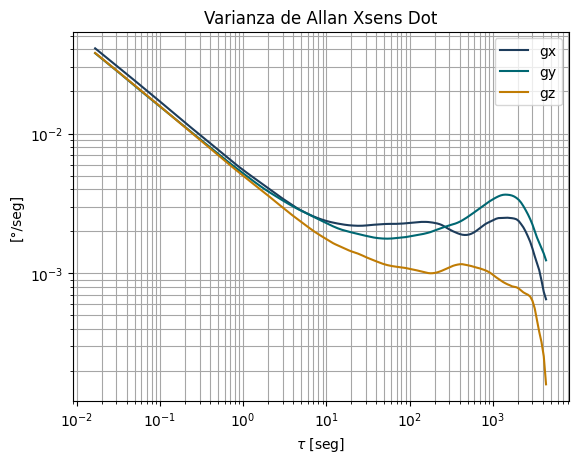

[array([1.66666667e-02, 3.33333333e-02, 5.00000000e-02, 6.66666667e-02,
        8.33333333e-02, 1.00000000e-01, 1.16666667e-01, 1.33333333e-01,
        1.50000000e-01, 1.66666667e-01, 1.83333333e-01, 2.00000000e-01,
        2.16666667e-01, 2.33333333e-01, 2.50000000e-01, 2.66666667e-01,
        2.83333333e-01, 3.00000000e-01, 3.33333333e-01, 3.50000000e-01,
        3.66666667e-01, 3.83333333e-01, 4.16666667e-01, 4.50000000e-01,
        4.66666667e-01, 5.00000000e-01, 5.33333333e-01, 5.66666667e-01,
        6.00000000e-01, 6.33333333e-01, 6.83333333e-01, 7.33333333e-01,
        7.66666667e-01, 8.16666667e-01, 8.66666667e-01, 9.33333333e-01,
        9.83333333e-01, 1.05000000e+00, 1.11666667e+00, 1.20000000e+00,
        1.26666667e+00, 1.35000000e+00, 1.43333333e+00, 1.53333333e+00,
        1.63333333e+00, 1.73333333e+00, 1.85000000e+00, 1.96666667e+00,
        2.08333333e+00, 2.21666667e+00, 2.36666667e+00, 2.51666667e+00,
        2.68333333e+00, 2.85000000e+00, 3.03333333e+00, 3.233333

In [9]:
def compute_allan_deviation_plot(main_folder_path, fs):
    """
    Calcula la desviación de Allan de los datos del giroscopio.
    
    Parámetros:
    - main_folder_path: Ruta principal que contiene las carpetas de los sensores.
    - sensor_folder: Nombre de la carpeta del sensor específico.
    - fs: Frecuencia de muestreo.
    """
    ts = 1.0 / fs
    
    # Ruta del archivo de calibración
    file_path = os.path.join(main_folder_path)
    
    # Lee el archivo de calibración sin encabezado, con tres columnas correspondientes a x, y, y z
    df = pd.read_csv(file_path, sep='\t', header=None)
    
    # Extrae las columnas por posición
    gyro_x = df.iloc[:, 0].dropna().values.flatten()
    gyro_y = df.iloc[:, 1].dropna().values.flatten()
    gyro_z = df.iloc[:, 2].dropna().values.flatten()

    # Calcula los ángulos del giroscopio
    thetax = np.cumsum(gyro_x) * ts  # [deg]
    thetay = np.cumsum(gyro_y) * ts
    thetaz = np.cumsum(gyro_z) * ts

    # Calcular las desviaciones de Allan
    (taux, adx) = AllanDeviation(thetax, fs, maxNumM=200)
    (tauy, ady) = AllanDeviation(thetay, fs, maxNumM=200)
    (tauz, adz) = AllanDeviation(thetaz, fs, maxNumM=200)

    
    # Colors
    azul = "#006772"
    amarillo = "#c07c04"
    azul_osc="#1d3c5b"
    
    # Gráfico en escala logarítmica
    plt.figure()
    plt.title('Varianza de Allan Xsens Dot')
    plt.plot(taux, adx, label='gx', color=azul_osc)
    plt.plot(tauy, ady, label='gy', color=azul)
    plt.plot(tauz, adz, label='gz', color=amarillo)
    plt.xlabel(r'$\tau$ [seg]')
    plt.ylabel('[°/seg]')
    plt.grid(True, which="both", ls="-", color='0.65')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    return [taux, adx, tauy, ady, tauz, adz]

# Ejemplo de uso
main_folder_path = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\gyro allan\tibia_gyroscope_calibration.txt"
fs = 60  # Frecuencia de muestreo

compute_allan_deviation_plot(main_folder_path,  fs)


In [5]:
# Diccionario para almacenar los datos de los acelerómetros, OJO están en m/s2 estas calibraciones
accelerometer_data = {
    "tibia_der": {
        "A": [
            [1.012103, -0.000051, 0.000574],
            [-0.000051, 1.012577, -0.000148],
            [0.0000574, -0.000148, 1.0007924]
        ],
        "b": [0.043918, -0.103321, -0.107844]
    },
    "muslo_der": {
        "A": [
            [1.006646, -0.000048, -0.000274],
            [-0.000048, 1.004406, -0.000090],
            [-0.000274, -0.000090, 1.003253]
        ],
        "b": [0.009487, 0.001722, -0.006293]
    }
}

#### LUEGO DE LA CALIBRACIÓN ESTATICA Y TENIENDO LOS VALORES DE LA CORRECCIÓN PODEMOS CONTINUAR 

In [4]:
# Diccionario para los datos del magnetómetro, ya lo calibré a mT
magnetometer_data = {
    "tibia": {
        "A": [
            [1.810815, 0.002595, 0.001618],
            [0.002595, 1.816431, 0.005933],
            [0.001618, 0.005933, 1.843712]
        ],
        "b": [-0.012773, 0.010590, -0.007774]
    },
    "muslo": {
        "A": [
            [0.874663, 0.016198, -0.027134],
            [0.016198, 0.872660, -0.071607],
            [-0.027134, -0.071607, 0.870045]
        ],
        "b": [0.040920, -0.008455, -0.028252]
    }
}

In [6]:
def create_calibrated_copies(main_folder):
    """
    Crea copias de los archivos CSV en subcarpetas, renombrándolos como 'calibrados',
    excluyendo las columnas ACC, Gyr, Mag y Quad. Solo crea la copia si no existe.
    
    Args:
        main_folder (str): Ruta a la carpeta principal.
    """
    # Recorre todas las subcarpetas
    for root, dirs, files in os.walk(main_folder):
        for file in files:
            if file.endswith('.csv') and "calibrados" not in file:
                # Construye la ruta completa al archivo CSV
                file_path = os.path.join(root, file)

                # Crea el nombre del nuevo archivo
                new_file_name = f"calibrados_{file}"
                new_file_path = os.path.join(root, new_file_name)

                # Verifica si la copia ya existe
                if os.path.exists(new_file_path):
                    print(f"La copia ya existe: {new_file_path}")
                else:
                    # Lee el archivo CSV
                    df = pd.read_csv(file_path)
                    
                    # Verifica que las columnas necesarias existan
                    columns_to_exclude = ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'Mag_X', 'Mag_Y', 'Mag_Z', 'Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']
                    
                    # Filtra las columnas a conservar
                    filtered_df = df.drop(columns=[col for col in columns_to_exclude if col in df.columns], errors='ignore')

                    # Añade columnas vacías para Acc, Gyr, Mag y Quats
                    for col in columns_to_exclude:
                        filtered_df[col] = None  # Espacio para las columnas

                    # Guarda el nuevo DataFrame como CSV
                    filtered_df.to_csv(new_file_path, index=False)
                    print(f"Copia creada: {new_file_path}")
    
    print("Proceso de creación de copias completado.")

# Ejemplo de uso:
main_folder = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores" 
create_calibrated_copies(main_folder)


La copia ya existe: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131146\calibrados_muslo_der_vale_D422CD002A84_20240827_131146.csv
La copia ya existe: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131146\calibrados_tibia_der_vale_D422CD002A8D_20240827_131146.csv
La copia ya existe: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_muslo_der_vale_D422CD002A84_20240827_131909.csv
La copia ya existe: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_tibia_der_vale_D422CD002A8D_20240827_131909.csv
La copia ya existe: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\132038\calibrados_muslo_der_vale_D422CD002A84_20240

#### Ahora que ya tenemos funciones de calibración estática, podemos generar las copias de calibración de los datos de movimiento

In [13]:
def update_acc_calibrated_data(original_folder, accelerometer_data):
    """
    Accede a los archivos calibrados y actualiza sus valores basándose en los archivos originales
    y el diccionario de datos de calibración estatica.
    Los datos se obtienen y calibran en m/s2

    Args:
        original_folder (str): Ruta de la carpeta que contiene los archivos.
        accelerometer_data (dict): Diccionario con matrices de calibración en m/s2 y vectores de sesgo b.
    """
    # Buscar todos los archivos en la carpeta y subcarpetas
    for root, dirs, files in os.walk(original_folder):
        for file in files:
            # Solo procesar archivos calibrados
            if 'calibrados' in file:
                calibrated_file_path = os.path.join(root, file)
                
                # Eliminar el prefijo 'calibrados_' para obtener el nombre del sensor correcto
                file_without_prefix = file.replace('calibrados_', '', 1)
                
                # Extraer el nombre del sensor, tomando solo hasta antes del segundo guion bajo
                sensor_name = '_'.join(file_without_prefix.split('_')[:2])
                
                # Verificar si el sensor está en los datos de calibración
                if sensor_name in accelerometer_data:
                    # Leer el archivo calibrado existente
                    df_calibrated = pd.read_csv(calibrated_file_path)

                    # Leer el archivo original correspondiente
                    original_file_name = file_without_prefix
                    original_file_path = os.path.join(root, original_file_name)

                    if os.path.exists(original_file_path):
                        # Leer el archivo original con pandas
                        rawData = pd.read_csv(original_file_path, delimiter=',')

                        # Convertir a matriz de numpy (extrayendo columnas de Acc_X, Acc_Y, Acc_Z)
                        rawData_values = rawData.iloc[:, 13:16].to_numpy()

                        # Imprimir los primeros 10 datos originales
                        print(f"Datos originales para {sensor_name} en {original_file_name}:")
                        print(rawData_values[:10])  # Muestra solo las primeras 10 filas

                        # Obtener A y b del diccionario de calibración
                        A = np.array(accelerometer_data[sensor_name]['A'])
                        b = np.array(accelerometer_data[sensor_name]['b'])

                        # Aplicar la calibración
                        N = len(rawData_values)
                        calibData = np.zeros((N, 3), dtype='float')
                        for i in range(N):
                            currMeas = rawData_values[i, :]  # Obtener medición actual
                            calibData[i, :] = A @ (currMeas - b)

                        # Llenar las columnas ACC_X, ACC_Y, ACC_Z
                        df_calibrated['Acc_X'] = calibData[:, 0]
                        df_calibrated['Acc_Y'] = calibData[:, 1]
                        df_calibrated['Acc_Z'] = calibData[:, 2]

                        # Guardar los datos actualizados
                        df_calibrated.to_csv(calibrated_file_path, index=False)
                        print(f"Datos calibrados actualizados en: {calibrated_file_path}")
                    else:
                        print(f"Archivo original no encontrado para: {original_file_path}")
                else:
                    print(f"No se encontraron datos de calibración para el sensor: {sensor_name}")

# Ejemplo de uso
original_folder = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores"
update_acc_calibrated_data(original_folder, accelerometer_data)

Datos originales para muslo_der en muslo_der_vale_D422CD002A84_20240827_131909.csv:
[[ 0.          0.          0.        ]
 [ 5.29338312  2.12186337 -8.08683395]
 [ 5.29889584  2.11866903 -8.07579136]
 [ 5.26284504  2.13669348 -8.04920483]
 [ 5.2617383   2.16043687 -8.05814266]
 [ 5.22884035  2.19108844 -8.06246376]
 [ 5.20685625  2.23489547 -8.06794262]
 [ 5.19431162  2.24745536 -8.07904243]
 [ 5.18795729  2.26235271 -8.08220482]
 [ 5.20022106  2.25327897 -8.0965519 ]]
Datos calibrados actualizados en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_muslo_der_vale_D422CD002A84_20240827_131909.csv
Datos originales para tibia_der en tibia_der_vale_D422CD002A8D_20240827_131909.csv:
[[ 0.          0.          0.        ]
 [-1.506953   -0.68094164 -9.6952343 ]
 [-1.5031997  -0.69229972 -9.70020103]
 [-1.50160193 -0.70324492 -9.72309589]
 [-1.50566709 -0.70689082 -9.74095249]
 [-1.47823644 -0.68087262 -9.

#### AHORA AJUSTAMOS MAGNETÓMETRO

In [16]:
def update_mag_calibrated_data(original_folder, magnetometer_data):
    """
    Accede a los archivos calibrados y actualiza sus valores basándose en los archivos originales
    y el diccionario de datos de calibración.

    Args:
        original_folder (str): Ruta de la carpeta que contiene los archivos.
        magnetometer_data (dict): Diccionario con matrices de calibración y vectores de sesgo.
    """
    # Buscar todos los archivos en la carpeta y subcarpetas
    for root, dirs, files in os.walk(original_folder):
        for file in files:
            # Solo procesar archivos calibrados
            if 'calibrados' in file:
                calibrated_file_path = os.path.join(root, file)
                
                # Extraer el nombre del sensor del archivo calibrado
                sensor_name = file.split('_')[1]  # Suponiendo que el nombre del sensor es el segundo elemento
                if sensor_name in magnetometer_data:
                    # Leer el archivo calibrado existente
                    df_calibrated = pd.read_csv(calibrated_file_path)

                    # Leer el archivo original correspondiente, eliminando 'calibrados' pero sin guion bajo
                    original_file_name = file.replace('calibrados_', '', 1)
                    original_file_path = os.path.join(root, original_file_name)

                    if os.path.exists(original_file_path):
                        # Leer el archivo original con pandas
                        rawData = pd.read_csv(original_file_path, delimiter=',')
                        
                        # Convertir a matriz de numpy
                        rawData_values = rawData.iloc[:, 20:23].to_numpy()  # Extraer columnas de Mag_X, Mag_Y, Mag_Z

                        # Obtener A y b del diccionario
                        A = np.array(magnetometer_data[sensor_name]['A'])
                        b = np.array(magnetometer_data[sensor_name]['b'])

                        # Aplicar la calibración
                        N = len(rawData_values)
                        calibData = np.zeros((N, 3), dtype='float')
                        for i in range(N):
                            currMeas = rawData_values[i, :]  # Obtener medición actual
                            calibData[i, :] = A @ (currMeas - b)
                            
                        # Llenar las columnas Mag_X, Mag_Y, Mag_Z
                        df_calibrated['Mag_X'] = calibData[:, 0]
                        df_calibrated['Mag_Y'] = calibData[:, 1]
                        df_calibrated['Mag_Z'] = calibData[:, 2]

                        # Guardar los datos actualizados
                        df_calibrated.to_csv(calibrated_file_path, index=False)
                        print(f"Datos calibrados actualizados en: {calibrated_file_path}")
                    else:
                        print(f"Archivo original no encontrado para: {original_file_path}")
                else:
                    print(f"No se encontraron datos de calibración para el sensor: {sensor_name}")

# Ejemplo de uso
original_folder = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores"
update_mag_calibrated_data(original_folder, magnetometer_data)


Datos calibrados actualizados en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_muslo_der_vale_D422CD002A84_20240827_131909.csv
Datos calibrados actualizados en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_tibia_der_vale_D422CD002A8D_20240827_131909.csv
Datos calibrados actualizados en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\132038\calibrados_muslo_der_vale_D422CD002A84_20240827_132038.csv
Datos calibrados actualizados en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\132038\calibrados_tibia_der_vale_D422CD002A8D_20240827_132038.csv
Datos calibrados actualizados en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos 

#### AHORA USAMOS LA FUNCION GYR CALIBRATION PARA AÑADIR LA CALIBRACIÓN DEL GIROSCOPIO

In [17]:
def gyr_calibration(main_folder_path):
    """
    Realiza la calibración de los datos del giroscopio. Esta no es static por lo que esta no la pasamos por magneto
    Para esta funcion empleamos ya los datos de movimiento porque la calibración es simplificada restando el sesgo
    
    Parámetros:
    - main_folder_path: Ruta principal donde están las carpetas de los sensores.
    
    Retorna:
    - Ninguno.
    """
    threshold = 100

    # Recorre todas las subcarpetas en la carpeta principal
    for sensor_folder in os.listdir(main_folder_path):
        sensor_path = os.path.join(main_folder_path, sensor_folder)

        # Verifica que sea una carpeta
        if os.path.isdir(sensor_path):
            # Recorre todos los archivos CSV en la subcarpeta
            for file_name in os.listdir(sensor_path):
                # Procesar solo los archivos que no comienzan con "calibrados_"
                if file_name.endswith(".csv") and not file_name.startswith("calibrados_"):
                    file_path = os.path.join(sensor_path, file_name)

                    # Lee el archivo CSV
                    df = pd.read_csv(file_path)
                    # Convertir las columnas de giroscopio a numéricas y manejar errores
                    df['Gyr_X'] = pd.to_numeric(df['Gyr_X'], errors='coerce')
                    df['Gyr_Y'] = pd.to_numeric(df['Gyr_Y'], errors='coerce')
                    df['Gyr_Z'] = pd.to_numeric(df['Gyr_Z'], errors='coerce')

                    # Reemplazar valores anómalos con NaN
                    df['Gyr_X'] = df['Gyr_X'].apply(lambda x: np.nan if abs(x) > threshold else x)
                    df['Gyr_Y'] = df['Gyr_Y'].apply(lambda x: np.nan if abs(x) > threshold else x)
                    df['Gyr_Z'] = df['Gyr_Z'].apply(lambda x: np.nan if abs(x) > threshold else x)

                    # Eliminar filas con NaN para evitar errores en futuros cálculos
                    #df.dropna(subset=['Gyr_X', 'Gyr_Y', 'Gyr_Z'], inplace=True)

                    # Calcular sesgo (bias) de los datos filtrados
                    gyro_x_bias = np.mean(df['Gyr_X'])
                    gyro_y_bias = np.mean(df['Gyr_Y'])
                    gyro_z_bias = np.mean(df['Gyr_Z'])

                    # Corregir lecturas y convertir a rad/seg
                    gyro_x = (df['Gyr_X'].values - gyro_x_bias) * (np.pi / 180)
                    gyro_y = (df['Gyr_Y'].values - gyro_y_bias) * (np.pi / 180)
                    gyro_z = (df['Gyr_Z'].values - gyro_z_bias) * (np.pi / 180)

                    # Nombre del sensor (sin extensión)
                    sensor_name = os.path.splitext(file_name)[0]

                    # Guarda los resultados en un archivo .txt dentro de la subcarpeta correspondiente
                    output_file_gyr = os.path.join(sensor_path, f"{sensor_name}_gyroscope_calibration.txt")

                    # Abre el archivo en modo escritura para sobreescribir contenido
                    with open(output_file_gyr, 'w') as f:
                        for x, y, z in zip(gyro_x, gyro_y, gyro_z):
                            f.write(f"{x}\t{y}\t{z}\n")

                    print(f"Archivo de calibración de giroscopio guardado para {sensor_name} en: {output_file_gyr}")

                    # Ahora busca el archivo calibrado correspondiente
                    calibrated_file_name = f"calibrados_{sensor_name}.csv"
                    calibrated_file_path = os.path.join(sensor_path, calibrated_file_name)

                    # Verifica que el archivo calibrado exista
                    if os.path.isfile(calibrated_file_path):
                        # Lee el archivo CSV de calibración
                        calibrated_df = pd.read_csv(calibrated_file_path)

                        # Asegúrate de que las columnas Gyr_X, Gyr_Y y Gyr_Z existan
                        if 'Gyr_X' in calibrated_df.columns and 'Gyr_Y' in calibrated_df.columns and 'Gyr_Z' in calibrated_df.columns:
                            # Reemplaza las columnas con los datos de calibración
                            calibrated_df['Gyr_X'] = gyro_x
                            calibrated_df['Gyr_Y'] = gyro_y
                            calibrated_df['Gyr_Z'] = gyro_z

                            # Guarda el archivo calibrado (sobrescribiendo)
                            calibrated_df.to_csv(calibrated_file_path, index=False)
                            print(f"Archivo calibrado actualizado: {calibrated_file_path}")

# Ejemplo de uso de la función
main_folder_path = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores" 
gyr_calibration(main_folder_path)


Archivo de calibración de giroscopio guardado para muslo_der_vale_D422CD002A84_20240827_131909 en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\muslo_der_vale_D422CD002A84_20240827_131909_gyroscope_calibration.txt
Archivo calibrado actualizado: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_muslo_der_vale_D422CD002A84_20240827_131909.csv
Archivo de calibración de giroscopio guardado para tibia_der_vale_D422CD002A8D_20240827_131909 en: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\tibia_der_vale_D422CD002A8D_20240827_131909_gyroscope_calibration.txt
Archivo calibrado actualizado: C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131909\calibrados_tibia_der_vale_D422CD002A8D_202408

acc [[-0.04439291  0.10460675  0.10791164]
 [-1.5751149  -0.58338735 -9.59499088]
 [-1.57131844 -0.59488774 -9.59995965]
 [-1.56971392 -0.60596729 -9.62287094]
 [-1.57383834 -0.60965619 -9.64074138]]
Diferencia promedio entre cuaterniones originales y filtrados (por componente):
[0.17208082 0.05736908 0.13831959 0.10040143]
Diferencia angular promedio entre cuaterniones originales y filtrados: 29.27 grados


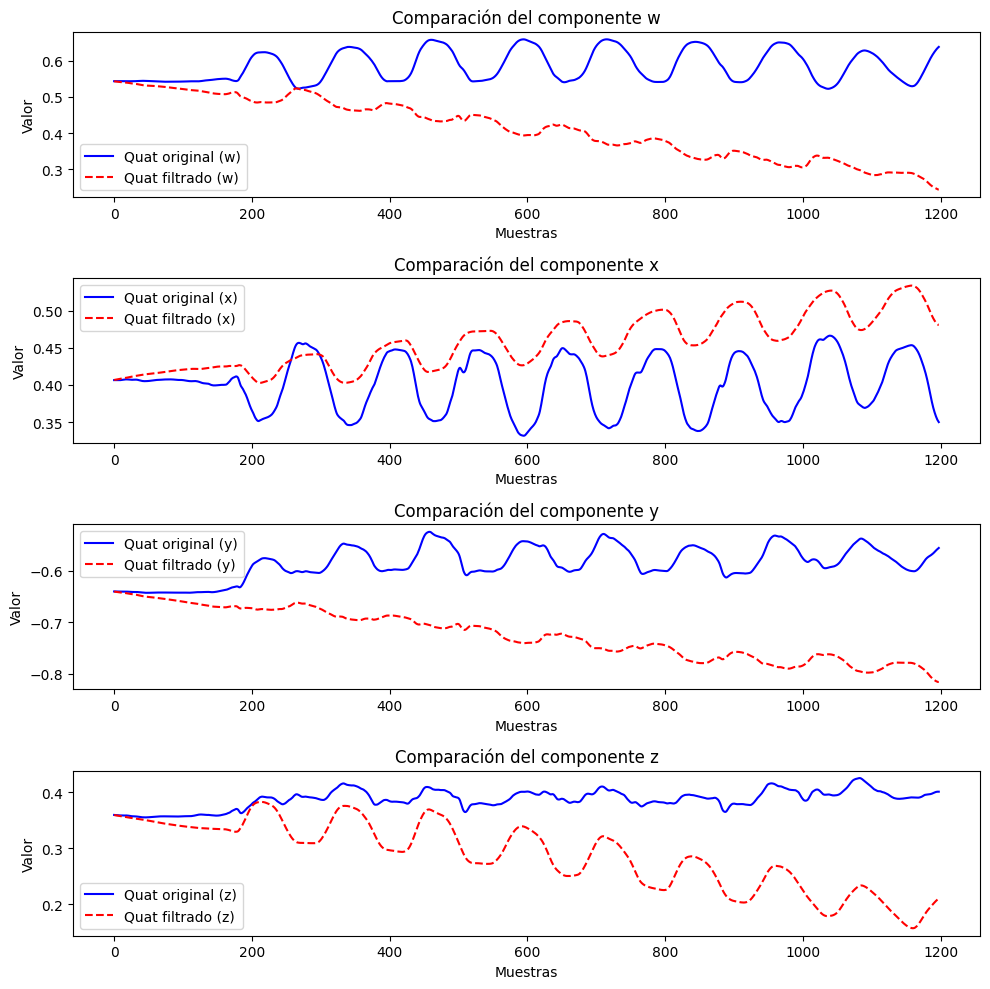

In [ ]:
def Madgwick_filter(main_folder_path, freq=60.0):
    """
    Aplica el filtro Madgwick a los datos de un DataFrame y genera gráficos comparando los cuaterniones originales y filtrados.
    
    Parámetros:
        main_folder_path (str): Ruta principal donde están las carpetas de los sensores.
        freq (float): Frecuencia de muestreo en Hz (por defecto 60 Hz).
        
    Devuelve:
        quaternions_filtered (np.ndarray): Cuaterniones filtrados por el filtro Madgwick.
    """
    # Recorre todas las subcarpetas en la carpeta principal de la ruta
    for sensor_folder in os.listdir(main_folder_path):
        sensor_path = os.path.join(main_folder_path, sensor_folder)

        # Verifica que sea una carpeta
        if os.path.isdir(sensor_path):
            dforg = None
            dfcal = None
            
            # Recorre todos los archivos CSV en la subcarpeta
            for file_name in os.listdir(sensor_path):
                file_path = os.path.join(sensor_path, file_name)
                
                # Identificar el archivo original
                if file_name.endswith(".csv") and not file_name.startswith("calibrados_"):
                    dforg = pd.read_csv(file_path)
                
                # Identificar el archivo calibrado
                elif file_name.endswith(".csv") and file_name.startswith("calibrados_"):
                    dfcal = pd.read_csv(file_path)
            
            # Verifica que ambos archivos (original y calibrado) están disponibles
            if dforg is not None and dfcal is not None:
                # Separar las columnas relevantes del archivo calibrado
                acc_data_cal = dfcal[['Acc_X', 'Acc_Y', 'Acc_Z']].to_numpy()
                gyr_data_cal = dfcal[['Gyr_X', 'Gyr_Y', 'Gyr_Z']].to_numpy()
                mag_data_cal = dfcal[['Mag_X', 'Mag_Y', 'Mag_Z']].to_numpy()
                print("acc", acc_data_cal[0:5])

                # Obtener los cuaterniones originales para la comparación
                quat_original = dforg[['Quat_W', 'Quat_X', 'Quat_Y', 'Quat_Z']].to_numpy()
                
                # Inicializar el filtro Madgwick
                madgwick = Madgwick()

                # Inicializa el primer cuaternión filtrado con el primero de los originales
                quaternions_filtered = np.zeros((len(quat_original), 4))
                quaternions_filtered[0] = quat_original[0]
                #quaternions_filtered[0]=[1.0,0.0,0.0,0.0]

                for i in range(1, len(acc_data_cal)):
                    # Verificar si alguna entrada es NaN antes de pasar al filtro
                    if np.isnan(gyr_data_cal[i]).any() or np.isnan(acc_data_cal[i]).any() or np.isnan(mag_data_cal[i]).any():
                        print(f"Datos faltantes en la muestra {i}")
                        quaternions_filtered[i] = quaternions_filtered[i-1]  # Mantener el último cuaternión válido
                        continue

                    # Aplicar el filtro Madgwick incluyendo los datos de magnetómetro
                    quaternions_filtered[i] = madgwick.updateMARG(
                        q=quaternions_filtered[i-1], 
                        gyr=gyr_data_cal[i], 
                        acc=acc_data_cal[i],
                        mag=mag_data_cal[i],
                    )

                    # Normalizar el cuaternión resultante
                    norm = np.linalg.norm(quaternions_filtered[i])
                    if norm > 0:
                        quaternions_filtered[i] /= norm
                    else:
                        print(f"Norma cero en la muestra {i}, manteniendo el cuaternión anterior.")
                        quaternions_filtered[i] = quaternions_filtered[i-1]

                    # Verificar si el cuaternión tiene NaN después del filtrado
                    if np.isnan(quaternions_filtered[i]).any():
                        print(f"NaN detectado en la muestra {i}:")
                        print("Giroscopio:", gyr_data_cal[i])
                        print("Acelerómetro:", acc_data_cal[i])
                        print("Magnetómetro:", mag_data_cal[i])
                        break

                # Comparar los cuaterniones filtrados con los originales
                quat_diff = np.abs(quaternions_filtered - quat_original)
                quat_diff_mean = np.mean(quat_diff, axis=0)

                print("Diferencia promedio entre cuaterniones originales y filtrados (por componente):")
                print(quat_diff_mean)

                # Calcular el ángulo entre cuaterniones originales y filtrados
                angle_diff = np.zeros(len(acc_data_cal))
                for i in range(len(acc_data_cal)):
                    q1 = quat_original[i]
                    q2 = quaternions_filtered[i]
                    dot_product = np.dot(q1, q2)
                    angle_diff[i] = 2 * np.arccos(np.clip(np.abs(dot_product), -1.0, 1.0)) * (180 / np.pi)

                mean_angle_diff = np.mean(angle_diff)
                print(f"Diferencia angular promedio entre cuaterniones originales y filtrados: {mean_angle_diff:.2f} grados")

                # Graficar cuaterniones originales y filtrados
                fig, axs = plt.subplots(4, 1, figsize=(10, 10))
                componentes = ['w', 'x', 'y', 'z']
                for i in range(4):
                    axs[i].plot(quat_original[:, i], label=f'Quat original ({componentes[i]})', color='b')
                    axs[i].plot(quaternions_filtered[:, i], label=f'Quat filtrado ({componentes[i]})', color='r', linestyle='--')
                    axs[i].set_title(f'Comparación del componente {componentes[i]}')
                    axs[i].legend()
                    axs[i].set_xlabel('Muestras')
                    axs[i].set_ylabel('Valor')

                # Ajustar el layout
                plt.tight_layout()
                plt.show()

                return quaternions_filtered

# Ejemplo de uso
main_folder_path = r"C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores" 
quaternions_filtrados = Madgwick_filter(main_folder_path, freq=60.0)

## Funciones útiles adicionales de manejo de archivos

In [ ]:
def check_decimal_separator(file_path):
    # Leer el archivo original
    rawData = np.genfromtxt(file_path, delimiter=',', dtype=str)  # Leer como texto para evitar errores

    # Imprimir las primeras filas del archivo
    print("Primeras filas del archivo:")
    for row in rawData[:5]:  # Imprimir solo las primeras 5 filas
        print(row)

    # Comprobar los separadores decimales
    decimal_found = any(',' in str(value) for row in rawData for value in row)
    if decimal_found:
        print("El archivo usa comas como separadores decimales.")
    else:
        print("El archivo usa puntos como separadores decimales.")

# Ejemplo de uso
file_path = r"C:\Users\Valentina\Documents\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores\131146\muslo_der_vale_D422CD002A84_20240827_131146.csv"  # Cambia el nombre del archivo
check_decimal_separator(file_path)

In [ ]:
def delete_calibrated_files(main_folder):
    """
    Elimina todos los archivos que contienen la palabra 'calibrados' en su nombre
    en la carpeta especificada y sus subcarpetas.

    Args:
        main_folder (str): Ruta a la carpeta principal donde se eliminarán los archivos.
    """
    # Recorre todos los archivos y subcarpetas en la carpeta principal
    for root, dirs, files in os.walk(main_folder):
        for file in files:
            if "calibrados" in file:
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"Archivo eliminado: {file_path}")
                except Exception as e:
                    print(f"No se pudo eliminar el archivo {file_path}: {e}")

# Ejemplo de uso:
main_folder = r"C:\Users\Valentina\Documents\TESIS 1\captura 2 - 27.08\datos vale_ dos sensores"  # Reemplaza esto con la ruta real de tu carpeta
delete_calibrated_files(main_folder)

print("Proceso de eliminación de archivos completado.")
